In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import requests
from PIL import Image
from io import BytesIO
import os
import sys
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from utils.image_utils import calculate_average_hsl_cv2
from sklearn.linear_model import LinearRegression

csv_files = glob.glob("../data/requests/*.csv")

# check data (if required, implement replacement of missing view counts or their data points)
for c in csv_files:
    df = pd.read_csv(c)
    for index, row in df.iterrows():
        image_url = row['thumbnail-url']
        views = row['viewCount']
        
        if len(image_url) < 10:
            print(f"Entry {index} in {os.path.basename(c)} has no thumbnail URL, please fix it manually!")
        try:
            views = int(views)
            views = str(views)
        except:
            views = ""
        if len(views) == 0:
            print(f"Entry {index} in {os.path.basename(c)} has no view count, please check this manually!")


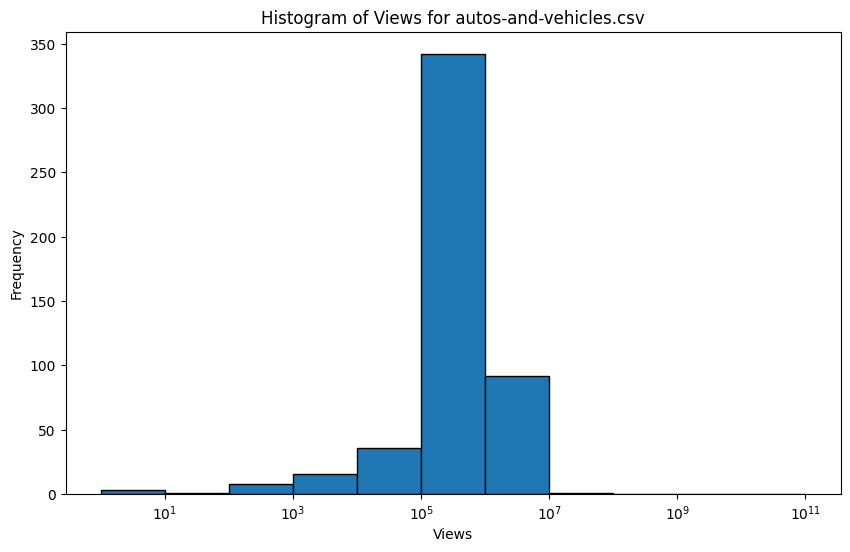

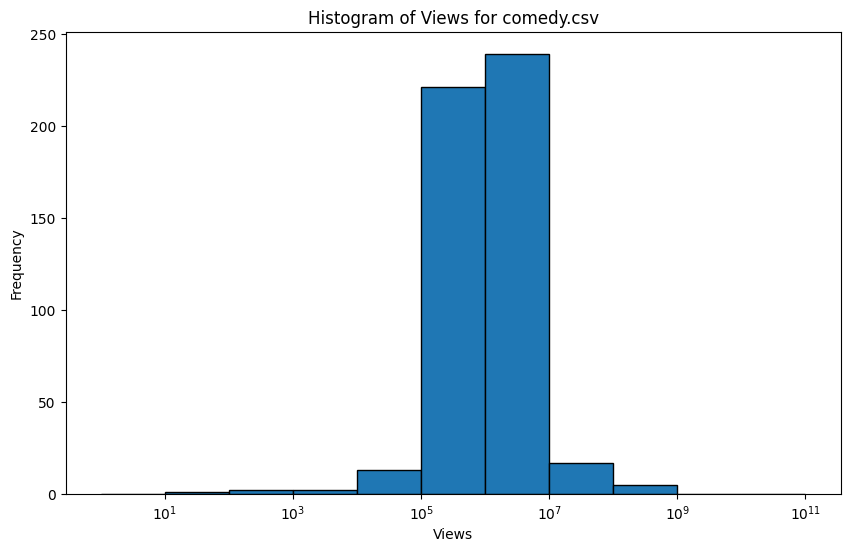

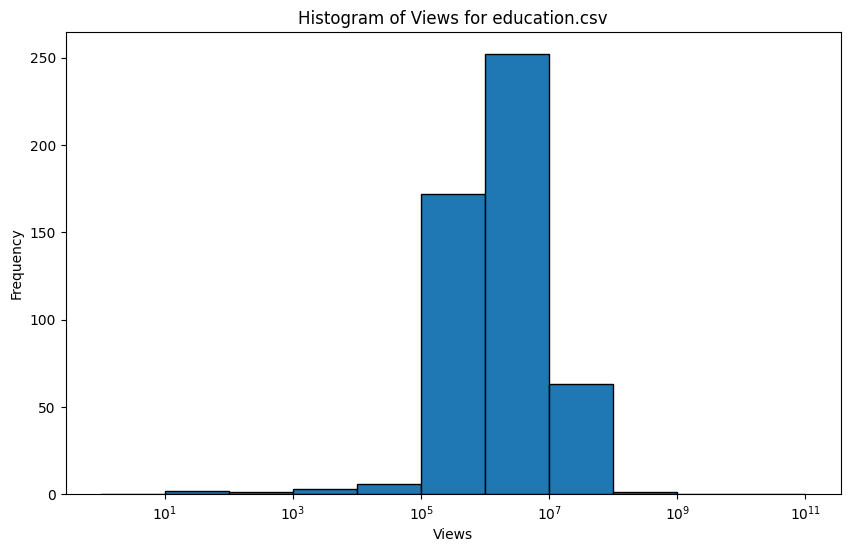

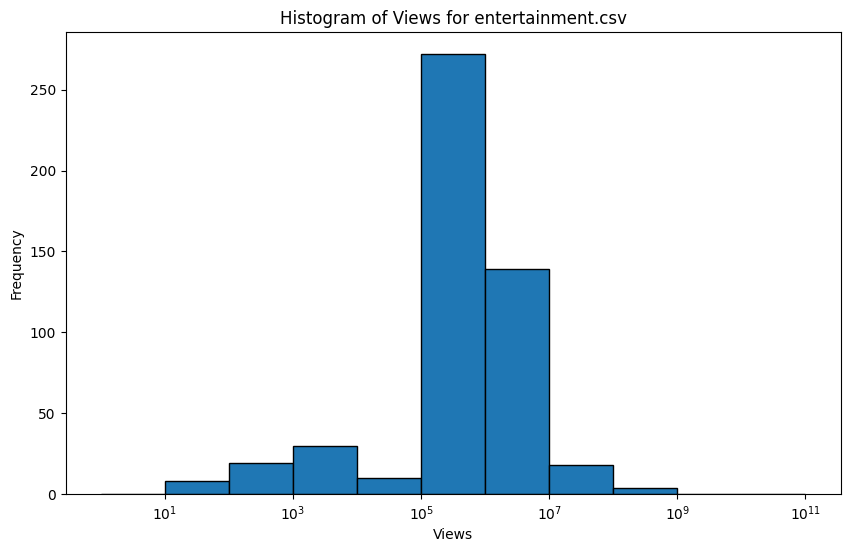

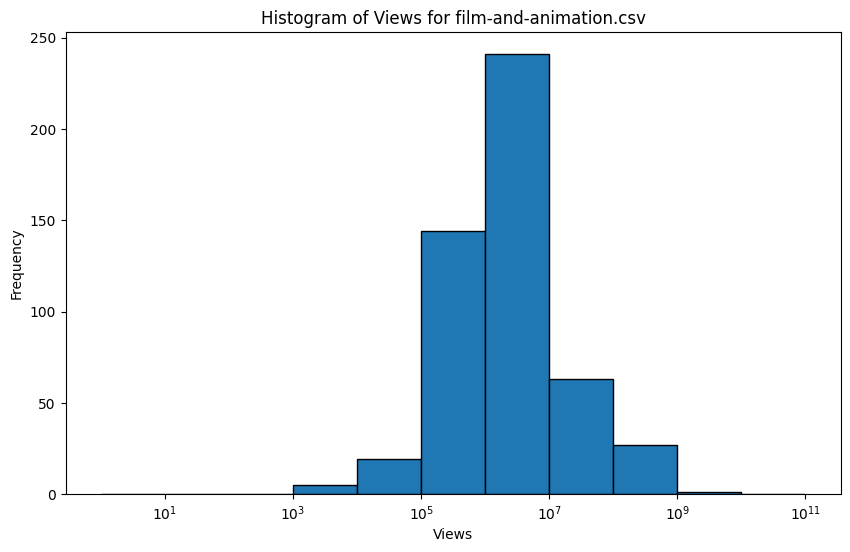

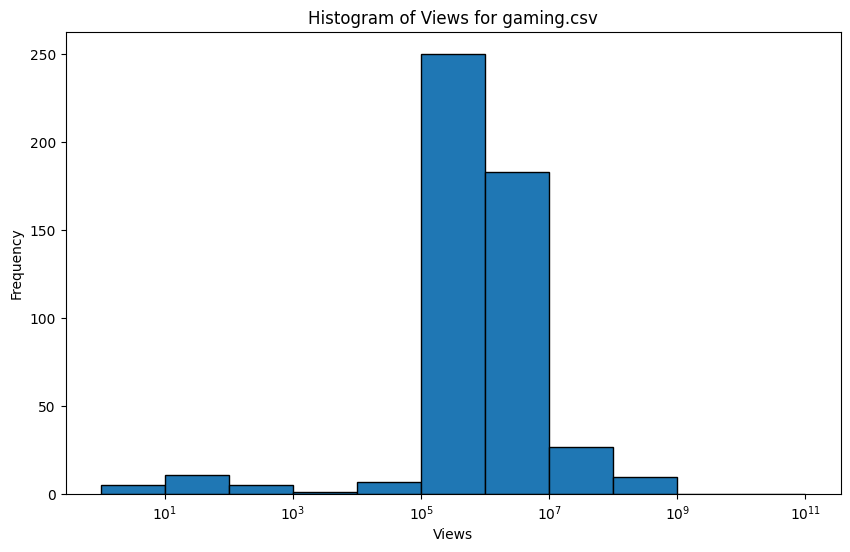

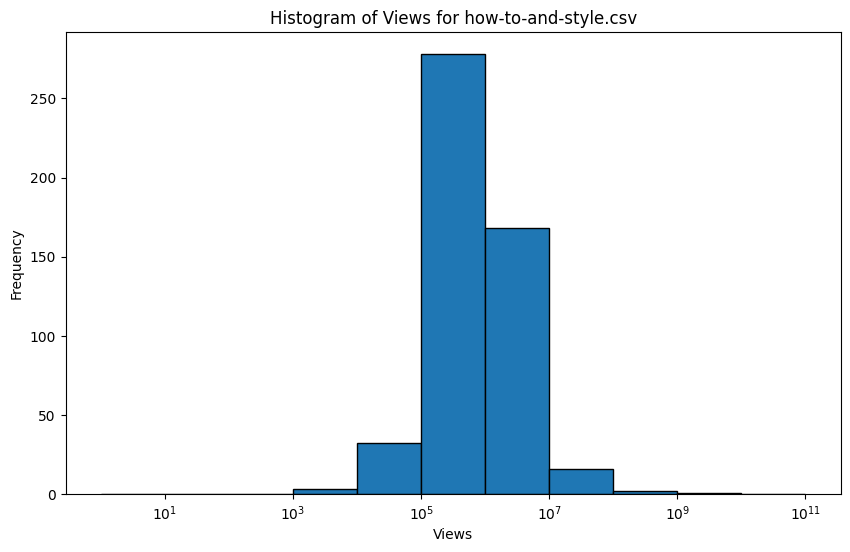

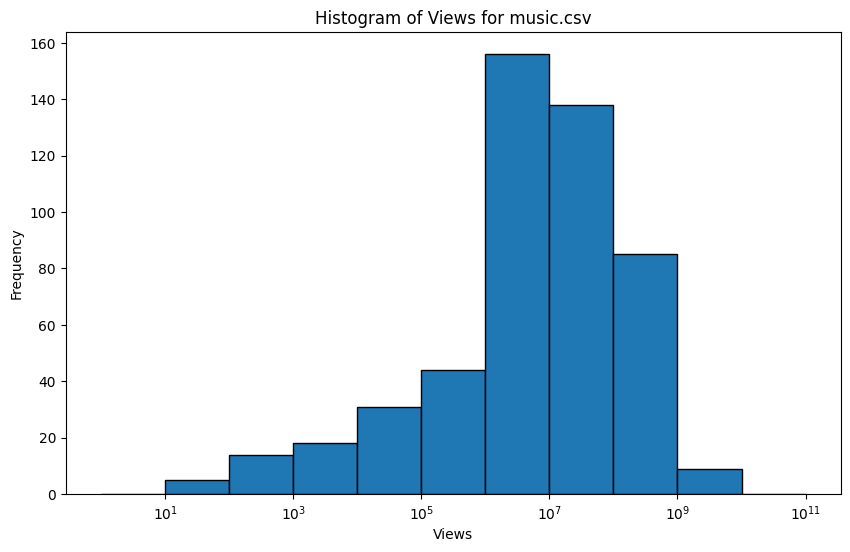

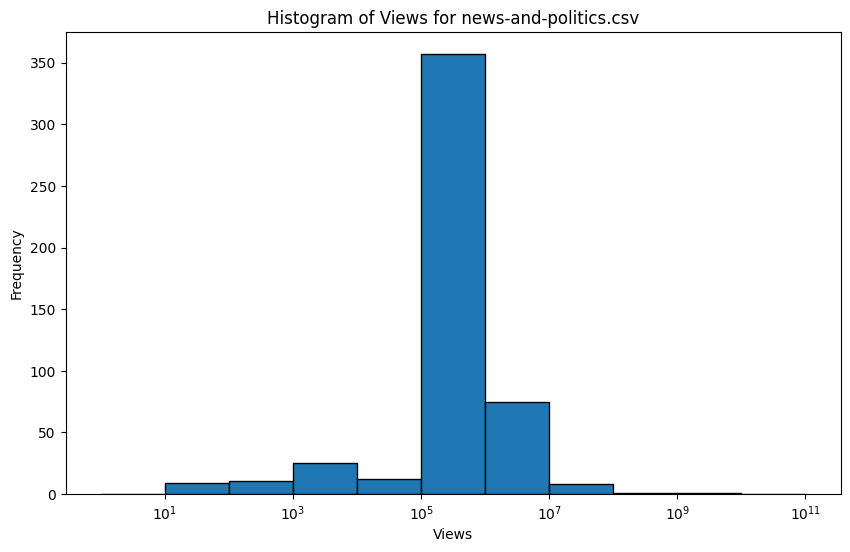

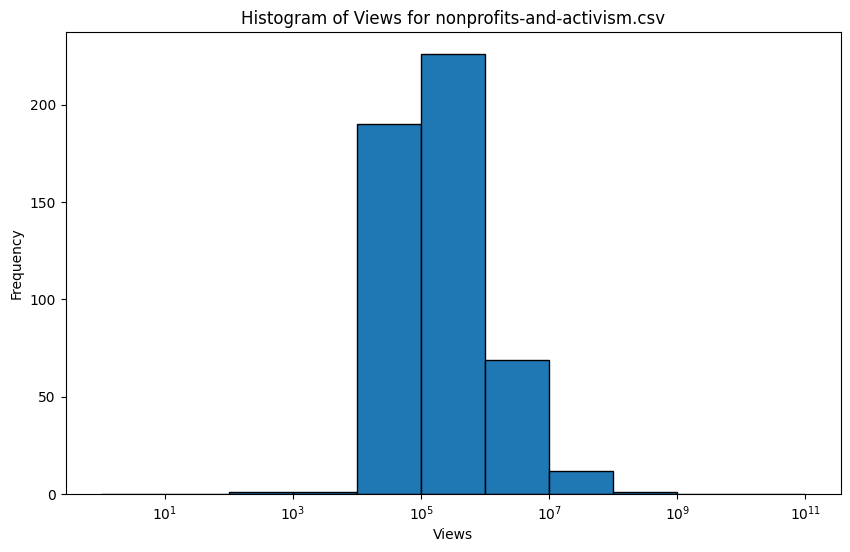

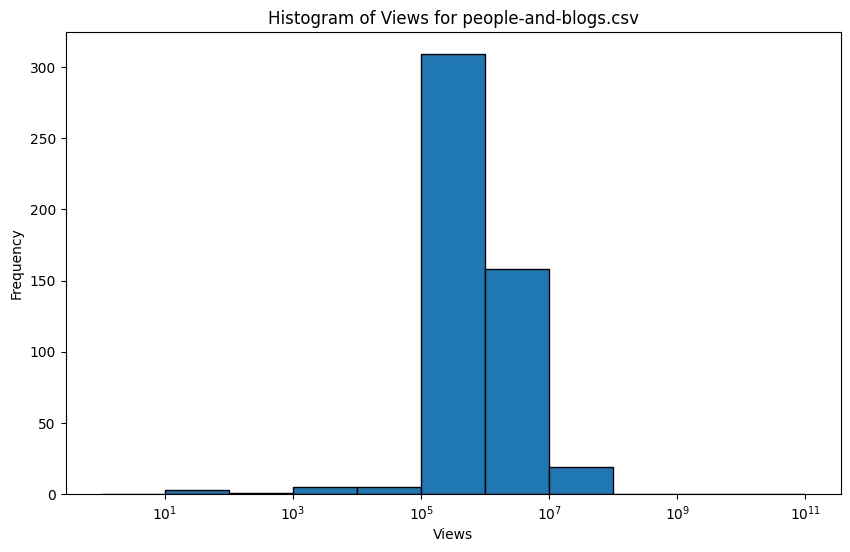

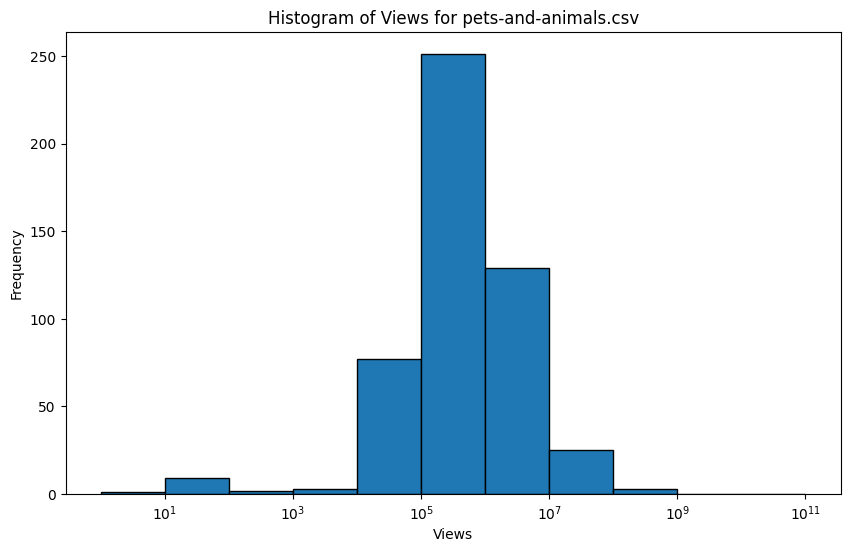

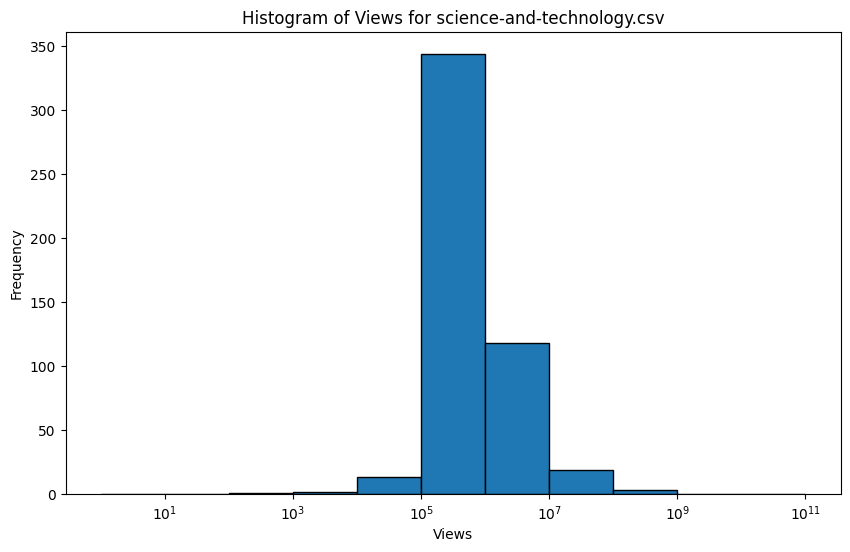

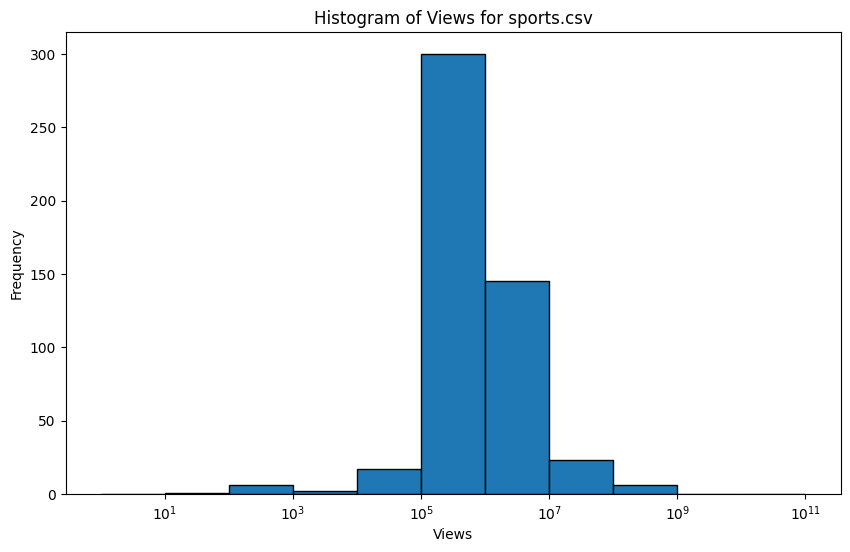

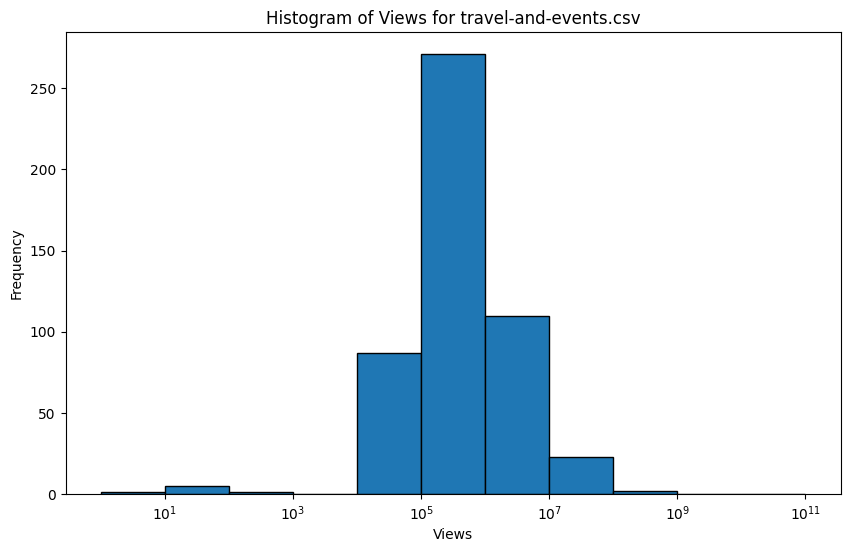

In [18]:
# like count histograms

for file in csv_files:
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Extract the 'views' column
    views = df['viewCount']
    
    # Define exponential bins
    #bins = [0, 1000, 10000, 100000, 500000, 1000000, 10000000, 100000000, 1000000000, np.inf]
    bins = np.logspace(0,11,num=12)
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(views, bins=bins, edgecolor='black')
    plt.xscale('log')
    plt.xlabel('Views')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Views for {os.path.basename(file)}')
    plt.show()

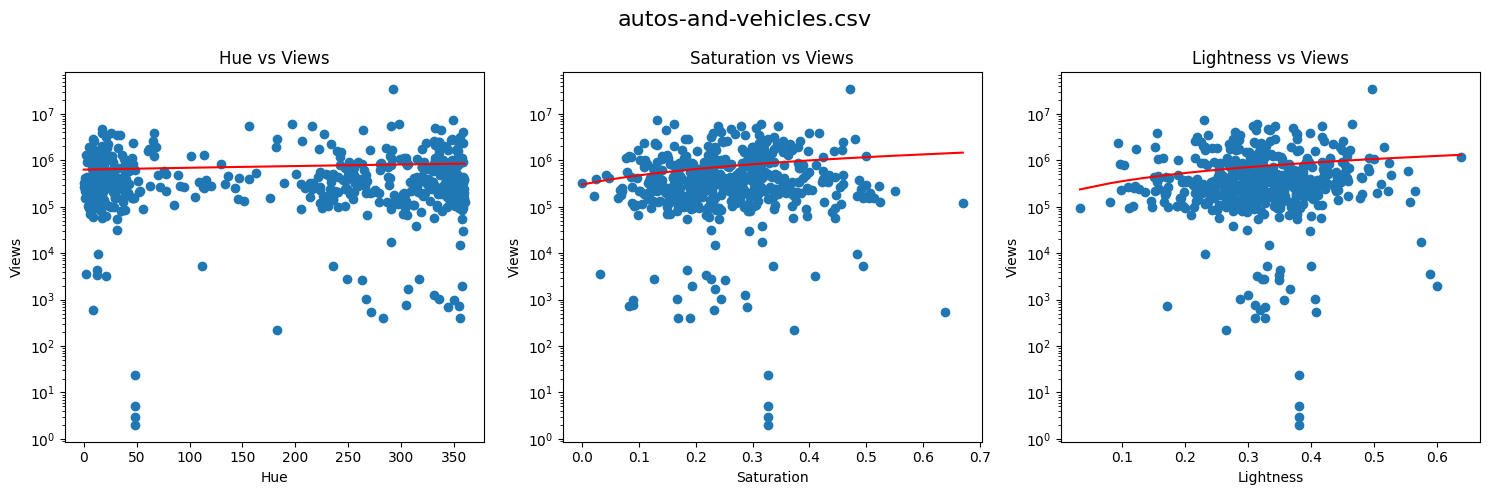

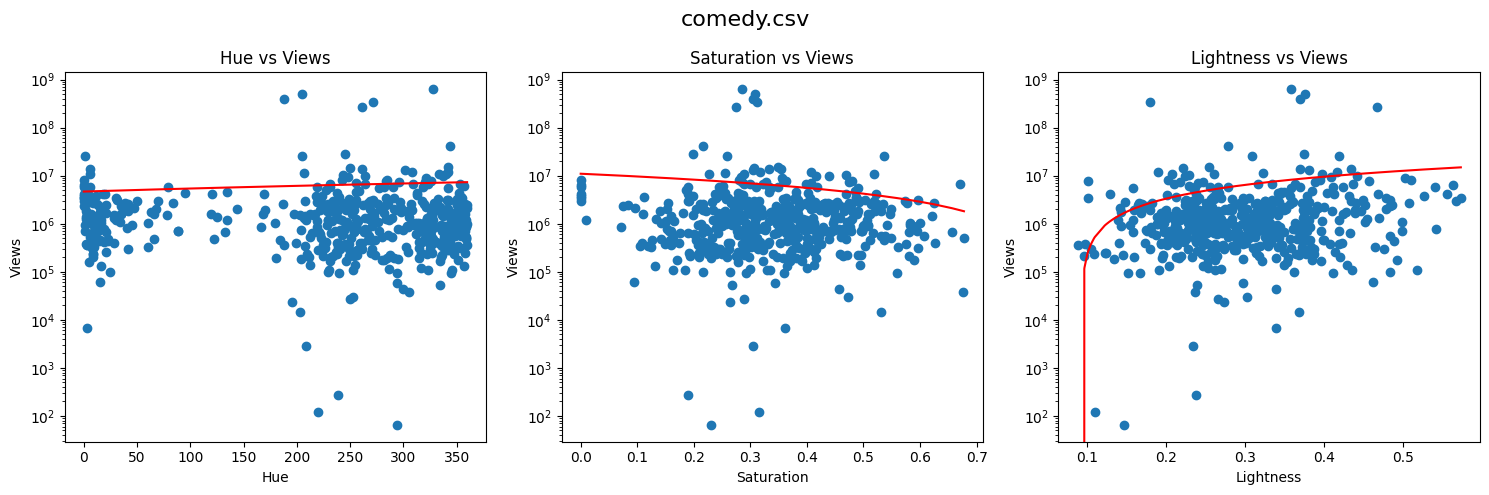

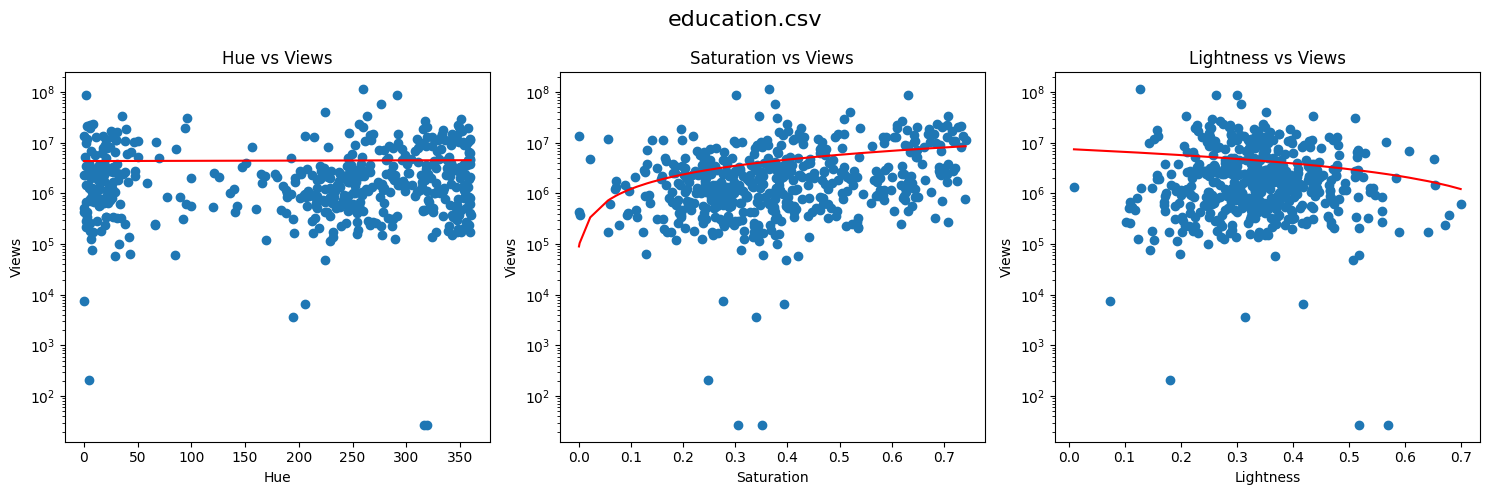

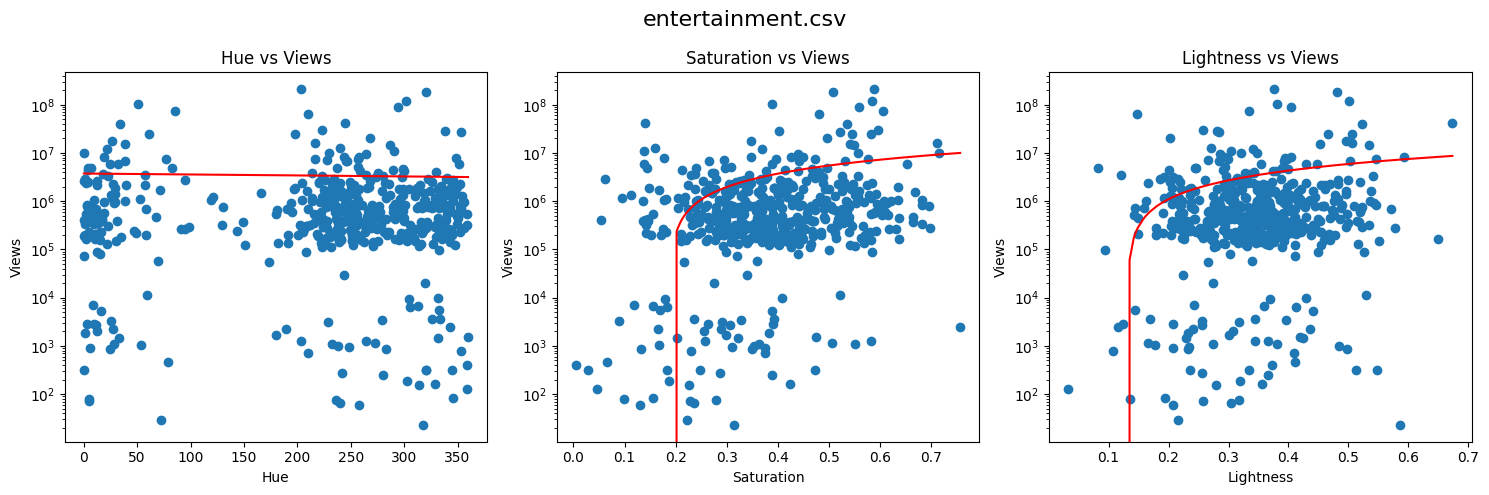

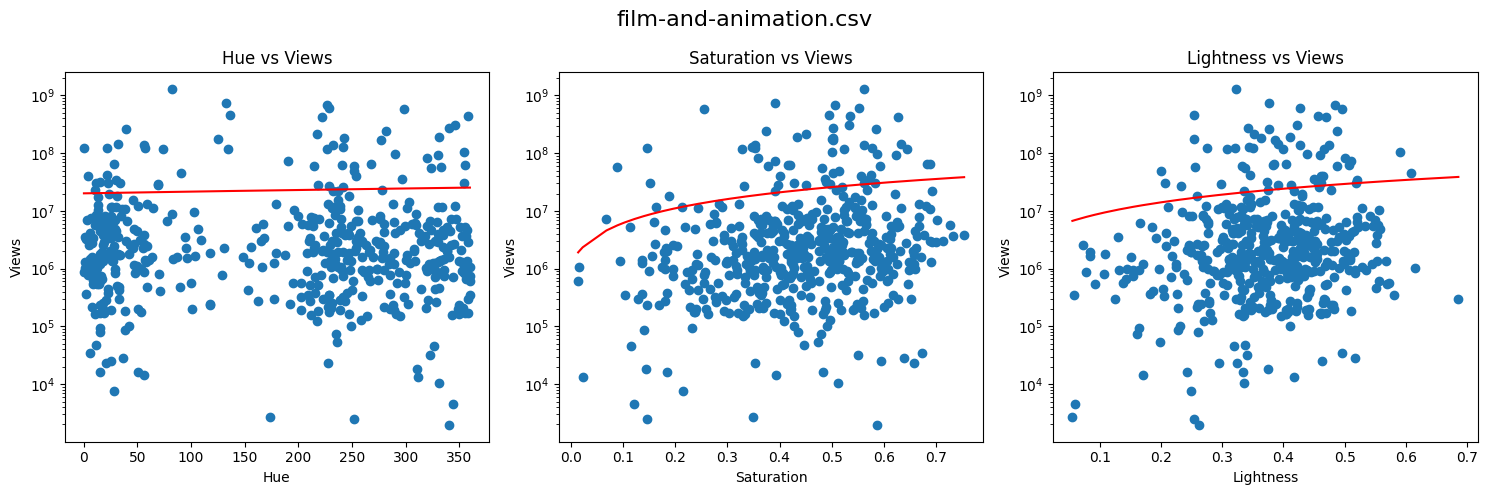

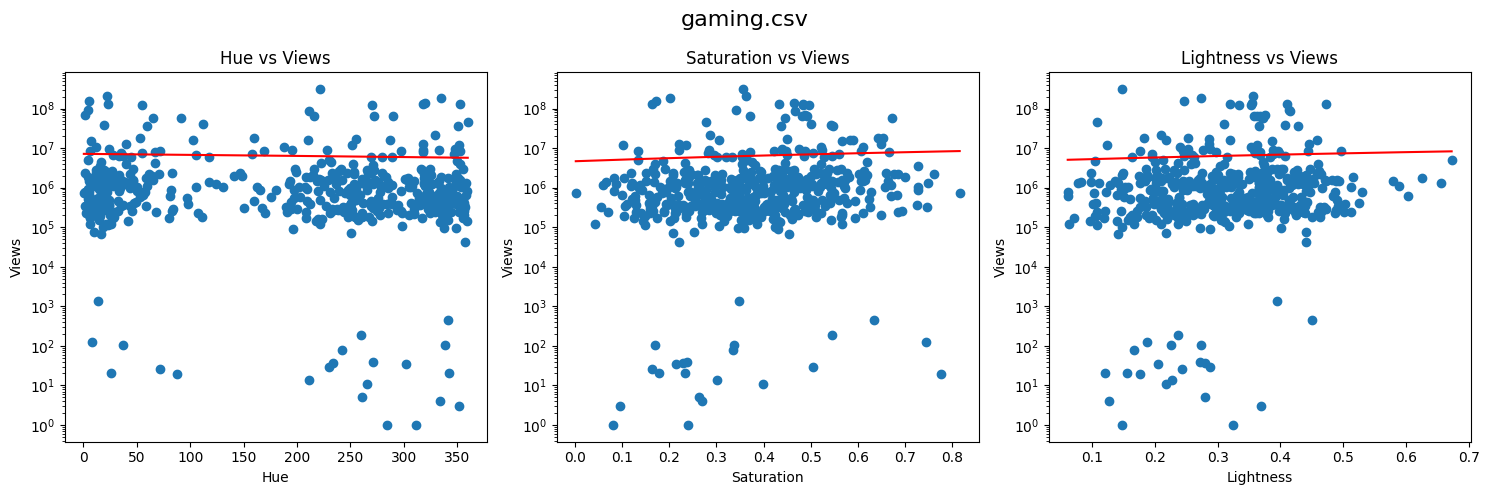

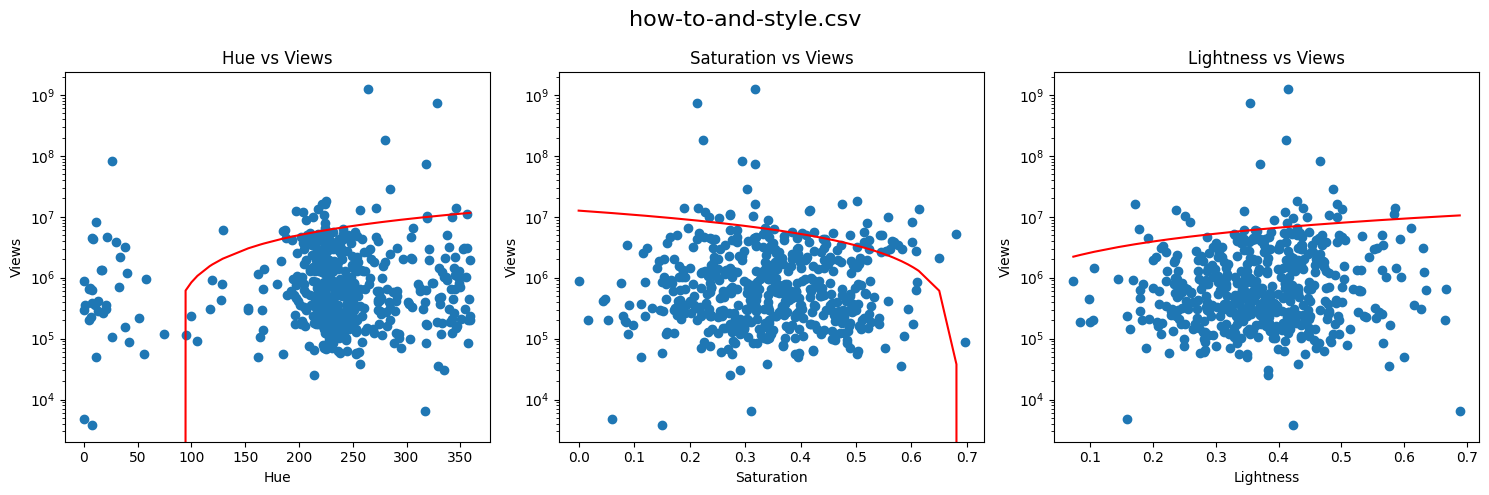

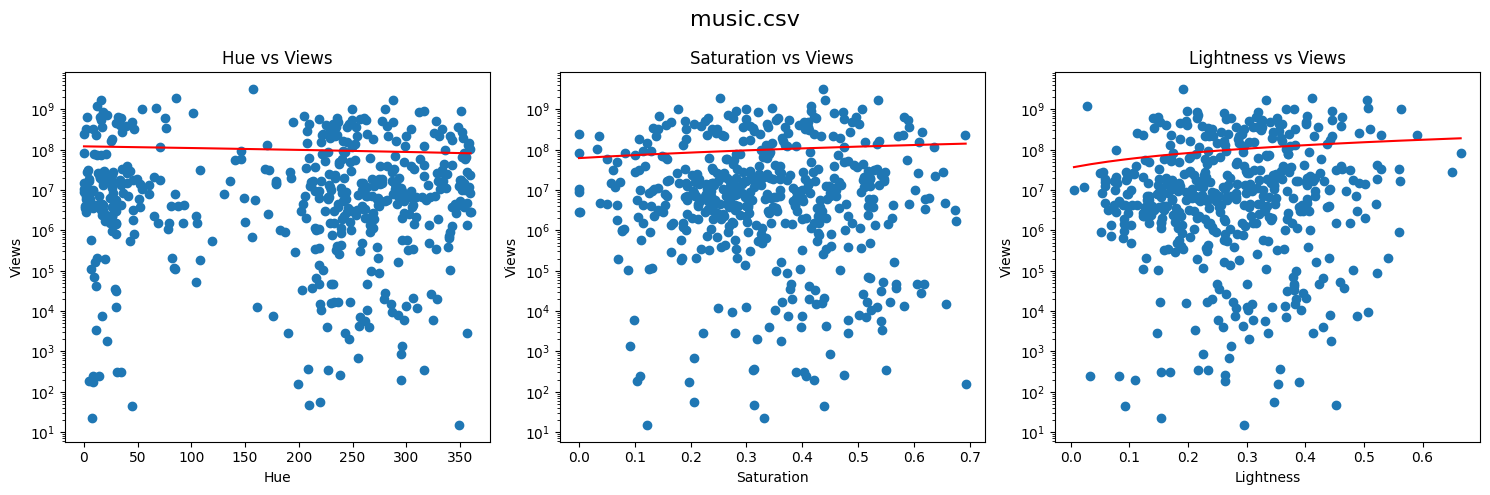

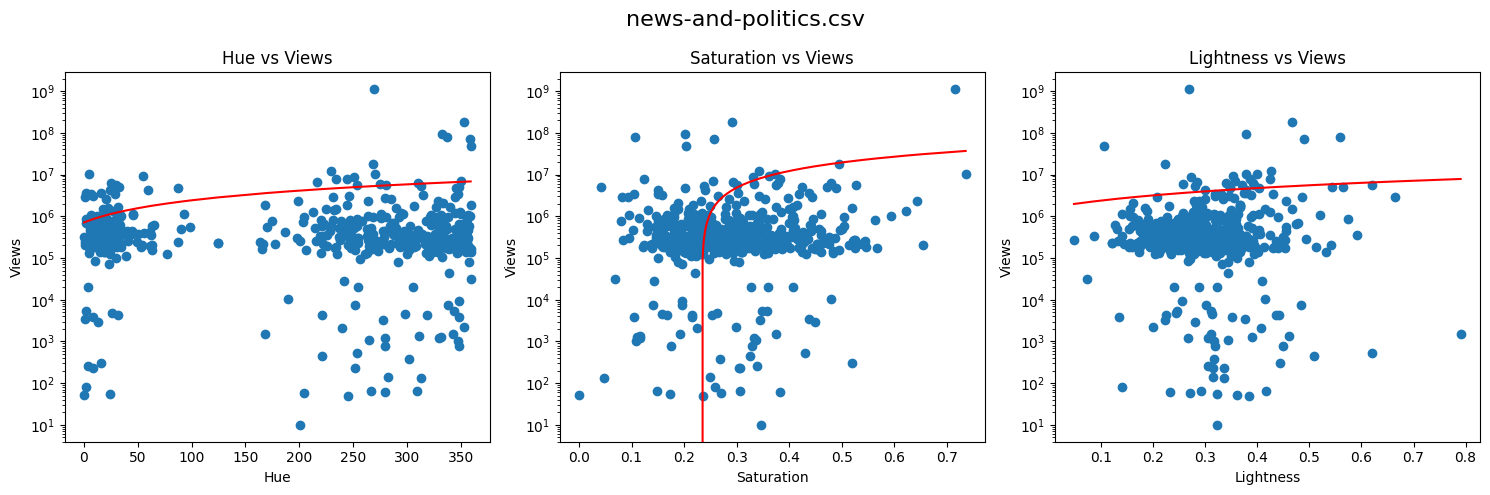

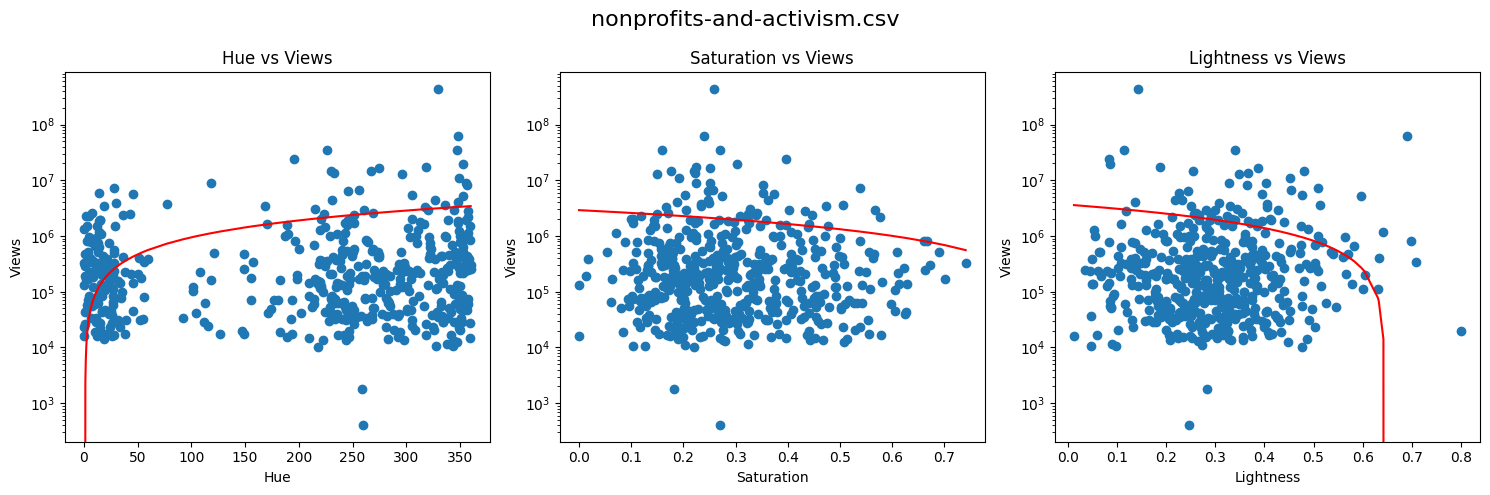

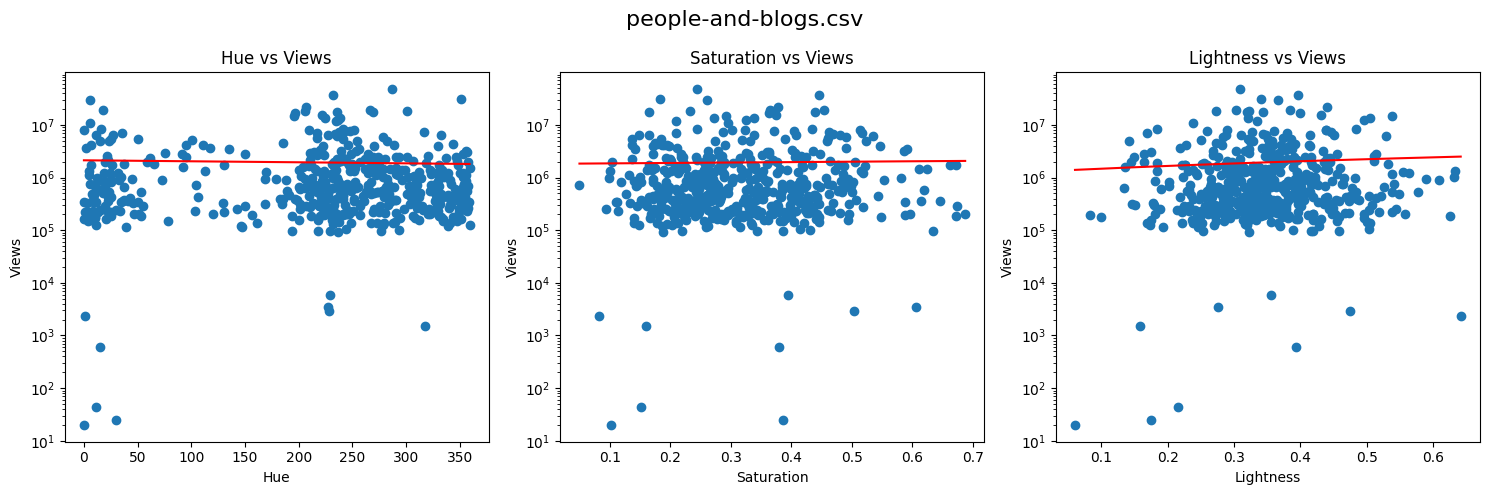

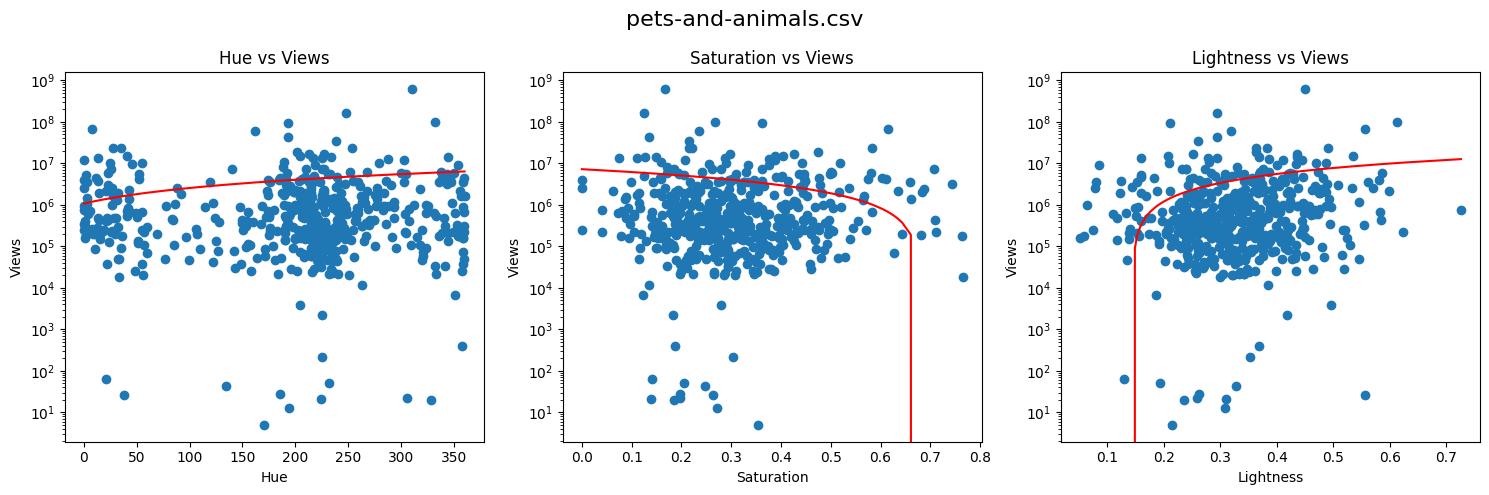

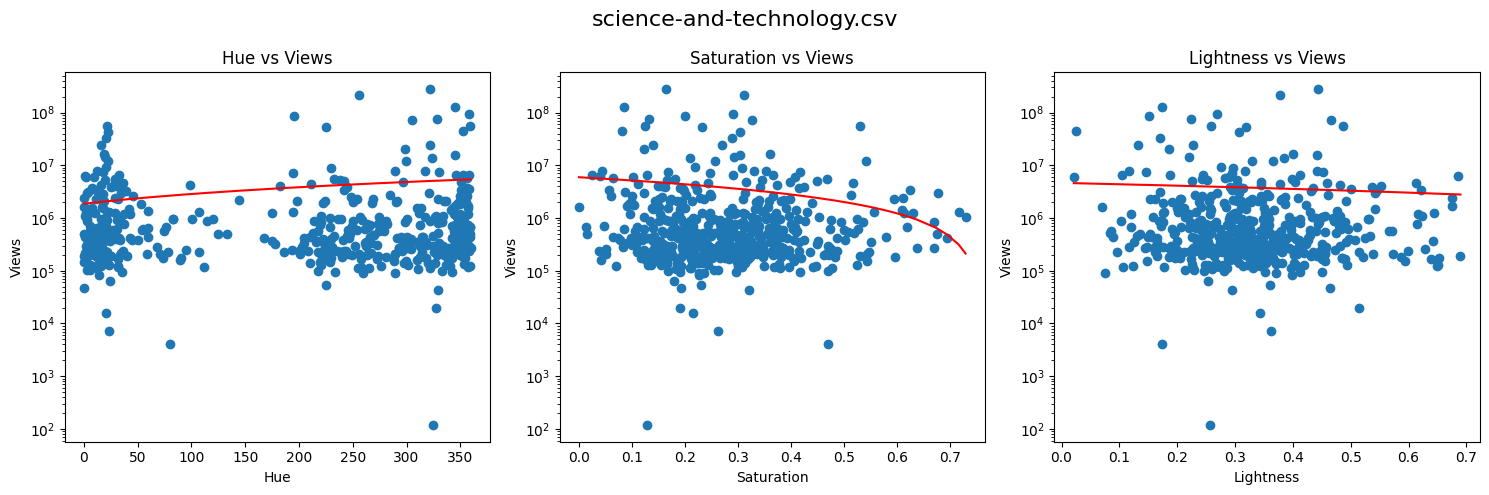

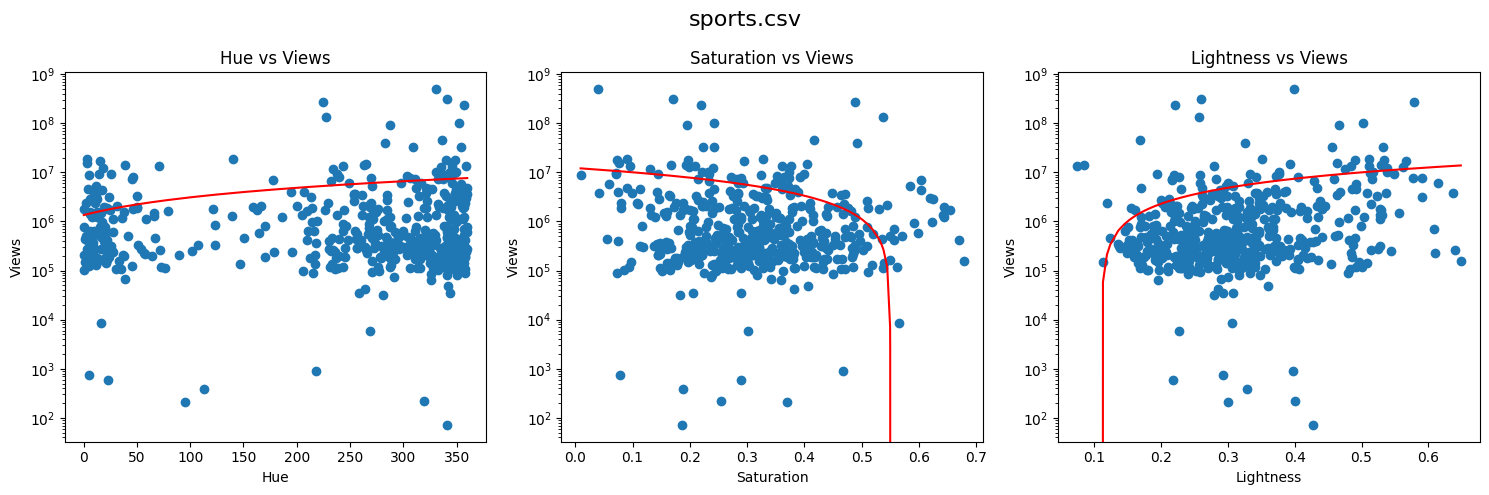

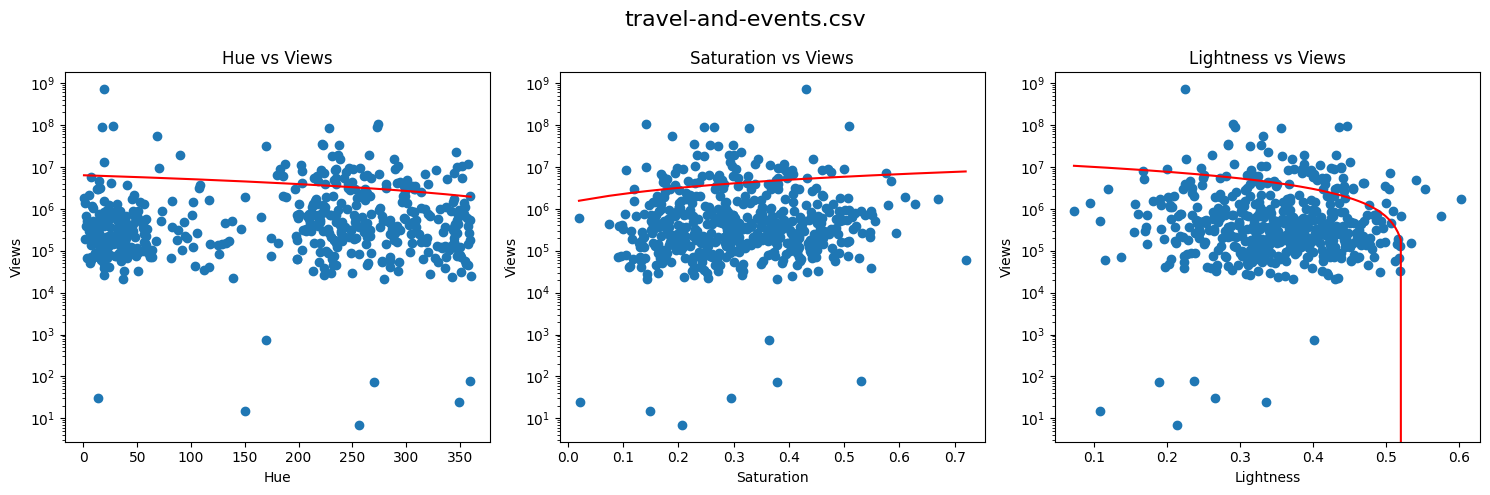

In [19]:
# initial thumbnail analysis

def download_image(url):
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content))
    else:
        raise Exception(f"Failed to download image from {url}")

def delete_image(image_path):
    if os.path.exists(image_path):
        os.remove(image_path)
    else:
        print(f"The file {image_path} does not exist")

def plot_image_values(filename, hue, saturation, lightness, views):
    plt.figure(figsize=(15, 5))

    def plot_and_fit(x, y, xlabel, title, subplot_index):
        plt.subplot(1, 3, subplot_index)
        plt.scatter(x, y)
        plt.xlabel(xlabel)
        plt.ylabel('Views')
        plt.title(title)
        plt.yscale('log')

        # Sort the data (regression line needs this)
        sorted_indices = np.argsort(x)
        x_sorted = np.array(x)[sorted_indices]
        y_sorted = np.array(y)[sorted_indices]

        model = LinearRegression()
        x_reshaped = x_sorted.reshape(-1, 1)
        model.fit(x_reshaped, y_sorted)
        y_pred = model.predict(x_reshaped)
        plt.plot(x_sorted, y_pred, color='red')

    plot_and_fit(hue, views, 'Hue', 'Hue vs Views', 1)
    plot_and_fit(saturation, views, 'Saturation', 'Saturation vs Views', 2)
    plot_and_fit(lightness, views, 'Lightness', 'Lightness vs Views', 3)

    plt.suptitle(filename, fontsize=16)
    plt.tight_layout()
    plt.show()

for c in csv_files:
    hue = []
    saturation = []
    lightness = []
    views = []
    df = pd.read_csv(c)
    for index, row in df.iterrows():
        image_url = row['thumbnail-url']
        try:
            image = download_image(image_url)
            result = calculate_average_hsl_cv2(np.array(image))
            
            hue.append(result["hue"])
            saturation.append(result["saturation"])
            lightness.append(result["lightness"])
            views.append(row["viewCount"])
        except Exception as e:
            print(f"Error processing image from {image_url}: {e}")
    plot_image_values(os.path.basename(c), hue, saturation, lightness, views)
